In [1]:
import os
import pandas as pd

# Input file path
input_file = r"C:\Users\saich\Downloads\ML_Datasets\CX2_16_1_30_12.xlsx"  # Your actual file path

# Get the directory of the input file
directory = os.path.dirname(input_file)

# Full path for the output file to be saved in the same directory
output_file = os.path.join(directory, 'CX2_16_1_30_12_filtered.xlsx')

# Sheet to keep
sheet_to_keep = 'Channel_1-006'

# Columns to remove
columns_to_remove = [
    'Step_Index', 'Cycle_Index', 'Charge_Energy(Wh)', 'Discharge_Energy(Wh)',
    'dV/dt(V/s)', 'Internal_Resistance(Ohm)', 'Is_FC_Data',
    'AC_Impedance(Ohm)', 'ACI_Phase_Angle(Deg)'
]

# Read only the desired sheet
df = pd.read_excel(input_file, sheet_name=sheet_to_keep)

# Drop the specified columns (ignore if any are missing)
df_cleaned = df.drop(columns=columns_to_remove, errors='ignore')

# Write the cleaned data to a new Excel file
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    df_cleaned.to_excel(writer, sheet_name=sheet_to_keep, index=False)

print(f"'{sheet_to_keep}' sheet cleaned and saved successfully to '{output_file}'.")


'Channel_1-006' sheet cleaned and saved successfully to 'C:\Users\saich\Downloads\ML_Datasets\CX2_16_1_30_12_filtered.xlsx'.


In [2]:
print(df.columns)


Index(['Data_Point', 'Test_Time(s)', 'Date_Time', 'Step_Time(s)', 'Step_Index',
       'Cycle_Index', 'Current(A)', 'Voltage(V)', 'Charge_Capacity(Ah)',
       'Discharge_Capacity(Ah)', 'Charge_Energy(Wh)', 'Discharge_Energy(Wh)',
       'dV/dt(V/s)', 'Internal_Resistance(Ohm)', 'Is_FC_Data',
       'AC_Impedance(Ohm)', 'ACI_Phase_Angle(Deg)'],
      dtype='object')


--- Charge_Capacity(Ah) ---
MAE:  0.0017
RMSE: 0.0037
R²:   1.0000

--- Discharge_Capacity(Ah) ---
MAE:  0.0015
RMSE: 0.0042
R²:   1.0000



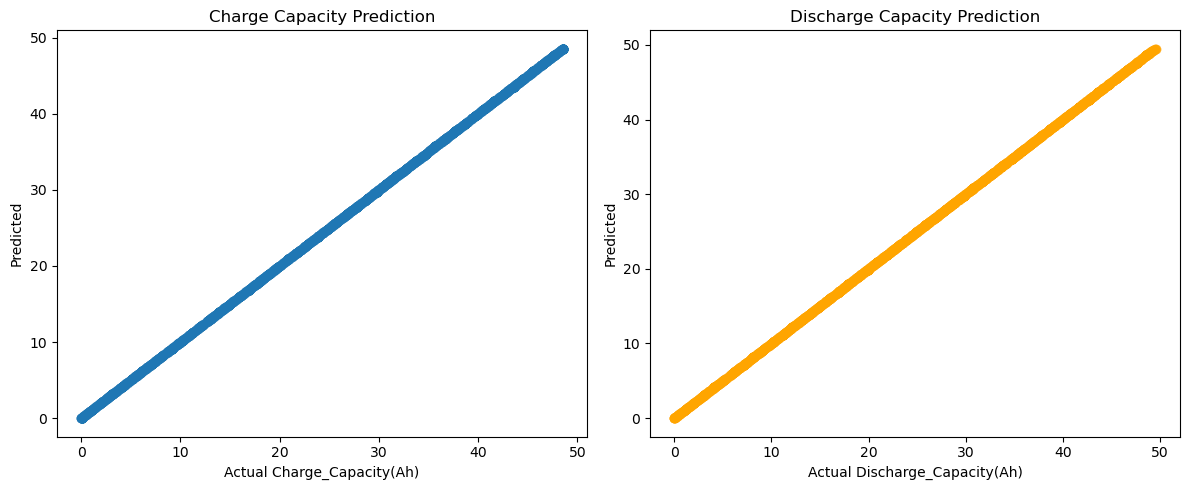

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load Excel file
file_path = r"C:\Users\saich\Downloads\ML_Datasets\CX2_16_1_30_12_filtered.xlsx"
df = pd.read_excel(file_path, sheet_name='Channel_1-006')

# Drop irrelevant columns
drop_cols = [
    'Step_Index', 'Cycle_Index', 'Charge_Energy(Wh)', 'Discharge_Energy(Wh)',
    'dV/dt(V/s)', 'Internal_Resistance(Ohm)', 'Is_FC_Data',
    'AC_Impedance(Ohm)', 'ACI_Phase_Angle(Deg)'
]
df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

# Drop rows with missing target values
df = df.dropna(subset=['Charge_Capacity(Ah)', 'Discharge_Capacity(Ah)'])

# Parse time features using the correct column name
df['Time'] = pd.to_datetime(df['Date_Time'], errors='coerce')
df = df.dropna(subset=['Time'])  # drop if parsing fails
df['hour'] = df['Time'].dt.hour
df['minute'] = df['Time'].dt.minute
df['second'] = df['Time'].dt.second
df['timestamp'] = df['Time'].astype(np.int64) // 10**9  # convert to UNIX time

# Define input (X) and outputs (y)
features = df.drop(columns=['Charge_Capacity(Ah)', 'Discharge_Capacity(Ah)', 'Time', 'Date_Time'])
X = features
y_charge = df['Charge_Capacity(Ah)']
y_discharge = df['Discharge_Capacity(Ah)']

# Split dataset
X_train, X_test, yc_train, yc_test = train_test_split(X, y_charge, test_size=0.2, random_state=42)
_, _, yd_train, yd_test = train_test_split(X, y_discharge, test_size=0.2, random_state=42)

# Model: Random Forest
model_charge = RandomForestRegressor(n_estimators=100, random_state=42)
model_discharge = RandomForestRegressor(n_estimators=100, random_state=42)

model_charge.fit(X_train, yc_train)
model_discharge.fit(X_train, yd_train)

# Predictions
yc_pred = model_charge.predict(X_test)
yd_pred = model_discharge.predict(X_test)

# Evaluation function
def evaluate(y_true, y_pred, label=""):
    print(f"--- {label} ---")
    print(f"MAE:  {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"R²:   {r2_score(y_true, y_pred):.4f}\n")

evaluate(yc_test, yc_pred, "Charge_Capacity(Ah)")
evaluate(yd_test, yd_pred, "Discharge_Capacity(Ah)")

# Optional: plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(yc_test, yc_pred, alpha=0.5)
plt.xlabel("Actual Charge_Capacity(Ah)")
plt.ylabel("Predicted")
plt.title("Charge Capacity Prediction")

plt.subplot(1, 2, 2)
plt.scatter(yd_test, yd_pred, alpha=0.5, color='orange')
plt.xlabel("Actual Discharge_Capacity(Ah)")
plt.ylabel("Predicted")
plt.title("Discharge Capacity Prediction")

plt.tight_layout()
plt.show()


In [4]:
comparison_df = pd.DataFrame({
    'Actual_Charge': yc_test.values,
    'Predicted_Charge': yc_pred,
    'Actual_Discharge': yd_test.values,
    'Predicted_Discharge': yd_pred
})
print(comparison_df.head(10))  # or use `.to_excel()` to export



   Actual_Charge  Predicted_Charge  Actual_Discharge  Predicted_Discharge
0      48.520171         48.520171         49.255211            49.257123
1       8.619998          8.616003          9.143398             9.143398
2       0.072350          0.072350          0.544718             0.545787
3      21.862931         21.862931         22.523259            22.521909
4      29.762987         29.762987         30.579172            30.579228
5      23.900673         23.900448         24.876391            24.876391
6      26.797682         26.797682         27.745313            27.744413
7      36.869257         36.865600         37.744734            37.744734
8      22.854512         22.854512         23.443764            23.442920
9       9.134734          9.134734          9.480882             9.482288


--- Charge_Capacity(Ah) - XGBoost ---
MAE:  0.0155
RMSE: 0.0269
R²:   1.0000

--- Discharge_Capacity(Ah) - XGBoost ---
MAE:  0.0161
RMSE: 0.0267
R²:   1.0000



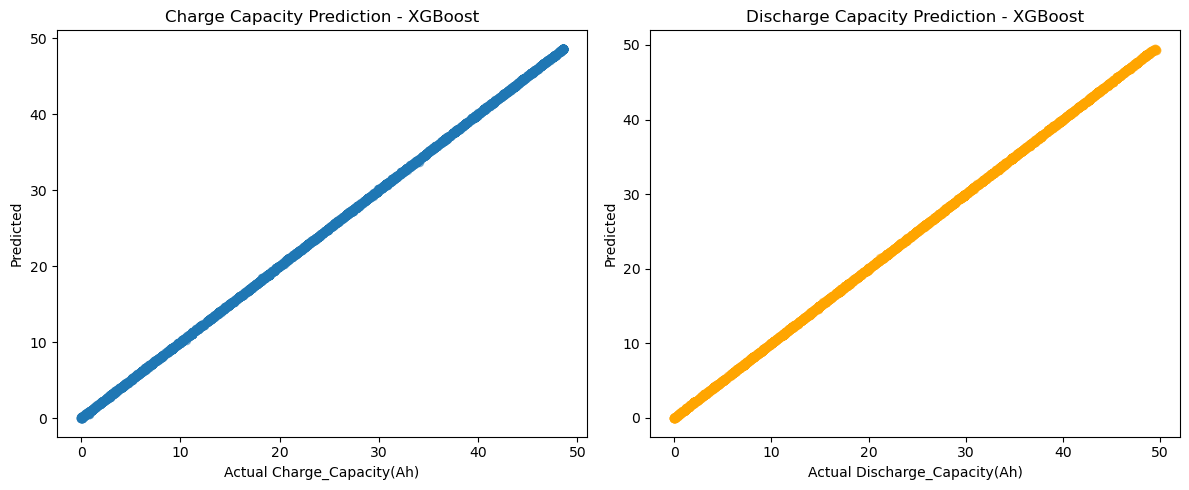

In [5]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define input (X) and outputs (y)
features = df.drop(columns=['Charge_Capacity(Ah)', 'Discharge_Capacity(Ah)', 'Time', 'Date_Time'])
X = features
y_charge = df['Charge_Capacity(Ah)']
y_discharge = df['Discharge_Capacity(Ah)']

# Split dataset
X_train, X_test, yc_train, yc_test = train_test_split(X, y_charge, test_size=0.2, random_state=42)
_, _, yd_train, yd_test = train_test_split(X, y_discharge, test_size=0.2, random_state=42)

# XGBoost model for Charge Capacity
xgb_model_charge = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model_charge.fit(X_train, yc_train)

# XGBoost model for Discharge Capacity
xgb_model_discharge = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model_discharge.fit(X_train, yd_train)

# Predictions
yc_pred_xgb = xgb_model_charge.predict(X_test)
yd_pred_xgb = xgb_model_discharge.predict(X_test)

# Evaluation function
def evaluate(y_true, y_pred, label=""):
    print(f"--- {label} ---")
    print(f"MAE:  {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"R²:   {r2_score(y_true, y_pred):.4f}\n")

evaluate(yc_test, yc_pred_xgb, "Charge_Capacity(Ah) - XGBoost")
evaluate(yd_test, yd_pred_xgb, "Discharge_Capacity(Ah) - XGBoost")

# Optional: plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(yc_test, yc_pred_xgb, alpha=0.5)
plt.xlabel("Actual Charge_Capacity(Ah)")
plt.ylabel("Predicted")
plt.title("Charge Capacity Prediction - XGBoost")

plt.subplot(1, 2, 2)
plt.scatter(yd_test, yd_pred_xgb, alpha=0.5, color='orange')
plt.xlabel("Actual Discharge_Capacity(Ah)")
plt.ylabel("Predicted")
plt.title("Discharge Capacity Prediction - XGBoost")

plt.tight_layout()
plt.show()


In [6]:
pip install XGBoost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
comparison_df = pd.DataFrame({
    'Actual_Charge': yc_test.values,
    'Predicted_Charge': yc_pred,
    'Actual_Discharge': yd_test.values,
    'Predicted_Discharge': yd_pred
})
print(comparison_df.head(10))  # or use `.to_excel()` to export


   Actual_Charge  Predicted_Charge  Actual_Discharge  Predicted_Discharge
0      48.520171         48.520171         49.255211            49.257123
1       8.619998          8.616003          9.143398             9.143398
2       0.072350          0.072350          0.544718             0.545787
3      21.862931         21.862931         22.523259            22.521909
4      29.762987         29.762987         30.579172            30.579228
5      23.900673         23.900448         24.876391            24.876391
6      26.797682         26.797682         27.745313            27.744413
7      36.869257         36.865600         37.744734            37.744734
8      22.854512         22.854512         23.443764            23.442920
9       9.134734          9.134734          9.480882             9.482288


--- Charge_Capacity(Ah) - XGBoost ---
MAE:  0.0155
RMSE: 0.0269
R²:   1.0000

--- Discharge_Capacity(Ah) - XGBoost ---
MAE:  0.0161
RMSE: 0.0267
R²:   1.0000

   Actual_Charge  Predicted_Charge  Actual_Discharge  Predicted_Discharge
0      48.520171         48.520397         49.255211            49.226696
1       8.619998          8.586884          9.143398             9.142627
2       0.072350          0.073935          0.544718             0.526703
3      21.862931         21.858231         22.523259            22.494089
4      29.762987         29.757803         30.579172            30.542408
5      23.900673         23.883526         24.876391            24.858702
6      26.797682         26.800570         27.745313            27.747972
7      36.869257         36.774761         37.744734            37.754826
8      22.854512         22.855106         23.443764            23.420012
9       9.134734          9.135027          9.480882             9.452099


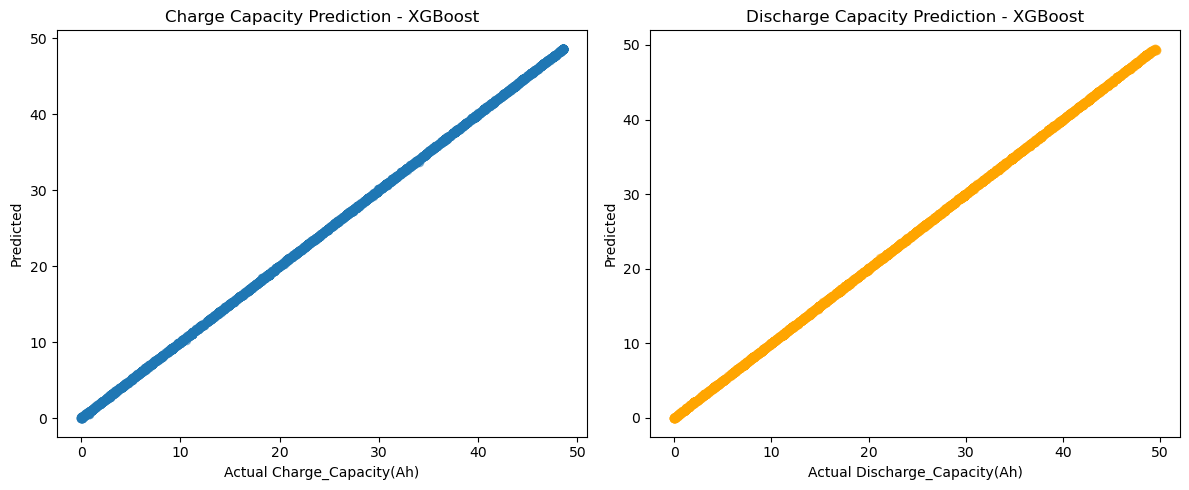

In [8]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Define input (X) and outputs (y)
features = df.drop(columns=['Charge_Capacity(Ah)', 'Discharge_Capacity(Ah)', 'Time', 'Date_Time'])
X = features
y_charge = df['Charge_Capacity(Ah)']
y_discharge = df['Discharge_Capacity(Ah)']

# Split dataset
X_train, X_test, yc_train, yc_test = train_test_split(X, y_charge, test_size=0.2, random_state=42)
_, _, yd_train, yd_test = train_test_split(X, y_discharge, test_size=0.2, random_state=42)

# XGBoost model for Charge Capacity
xgb_model_charge = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model_charge.fit(X_train, yc_train)

# XGBoost model for Discharge Capacity
xgb_model_discharge = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model_discharge.fit(X_train, yd_train)

# Predictions
yc_pred_xgb = xgb_model_charge.predict(X_test)
yd_pred_xgb = xgb_model_discharge.predict(X_test)

# Evaluation function
def evaluate(y_true, y_pred, label=""):
    print(f"--- {label} ---")
    print(f"MAE:  {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"R²:   {r2_score(y_true, y_pred):.4f}\n")

evaluate(yc_test, yc_pred_xgb, "Charge_Capacity(Ah) - XGBoost")
evaluate(yd_test, yd_pred_xgb, "Discharge_Capacity(Ah) - XGBoost")

# Comparison DataFrame
comparison_df = pd.DataFrame({
    'Actual_Charge': yc_test.values,
    'Predicted_Charge': yc_pred_xgb,
    'Actual_Discharge': yd_test.values,
    'Predicted_Discharge': yd_pred_xgb
})

# Print comparison
print(comparison_df.head(10))

# Optional: plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(yc_test, yc_pred_xgb, alpha=0.5)
plt.xlabel("Actual Charge_Capacity(Ah)")
plt.ylabel("Predicted")
plt.title("Charge Capacity Prediction - XGBoost")

plt.subplot(1, 2, 2)
plt.scatter(yd_test, yd_pred_xgb, alpha=0.5, color='orange')
plt.xlabel("Actual Discharge_Capacity(Ah)")
plt.ylabel("Predicted")
plt.title("Discharge Capacity Prediction - XGBoost")

plt.tight_layout()
plt.show()


--- Charge_Capacity(Ah) - Random Forest ---
MAE:  0.0017
RMSE: 0.0037
R²:   1.0000

--- Discharge_Capacity(Ah) - Random Forest ---
MAE:  0.0015
RMSE: 0.0042
R²:   1.0000

   Actual_Charge  Predicted_Charge  Actual_Discharge  Predicted_Discharge
0      48.520171         48.520171         49.255211            49.257123
1       8.619998          8.616003          9.143398             9.143398
2       0.072350          0.072350          0.544718             0.545787
3      21.862931         21.862931         22.523259            22.521909
4      29.762987         29.762987         30.579172            30.579228
5      23.900673         23.900448         24.876391            24.876391
6      26.797682         26.797682         27.745313            27.744413
7      36.869257         36.865600         37.744734            37.744734
8      22.854512         22.854512         23.443764            23.442920
9       9.134734          9.134734          9.480882             9.482288


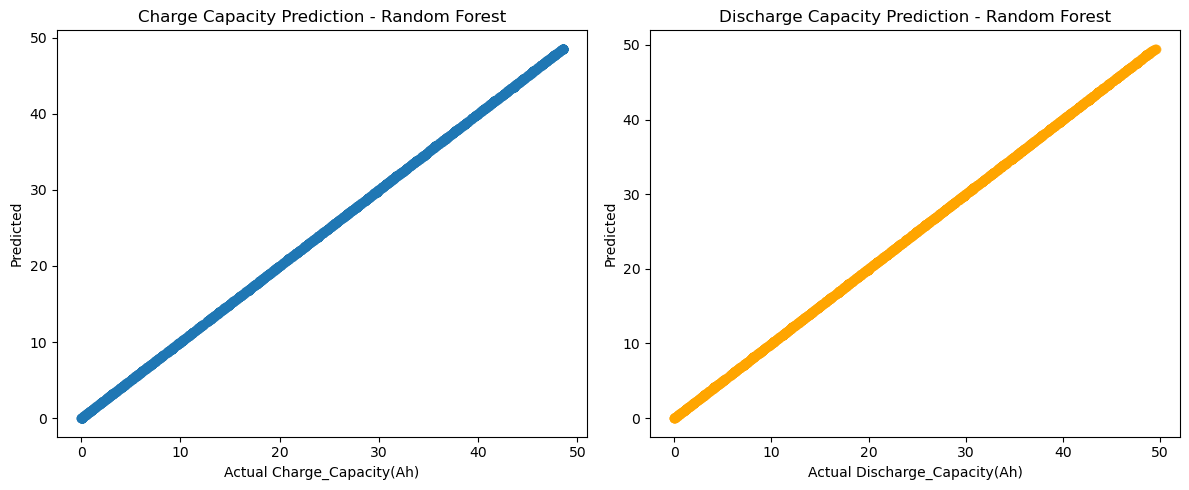

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Define input (X) and outputs (y)
features = df.drop(columns=['Charge_Capacity(Ah)', 'Discharge_Capacity(Ah)', 'Time', 'Date_Time'])
X = features
y_charge = df['Charge_Capacity(Ah)']
y_discharge = df['Discharge_Capacity(Ah)']

# Split dataset
X_train, X_test, yc_train, yc_test = train_test_split(X, y_charge, test_size=0.2, random_state=42)
_, _, yd_train, yd_test = train_test_split(X, y_discharge, test_size=0.2, random_state=42)

# Random Forest model for Charge Capacity
rf_model_charge = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_charge.fit(X_train, yc_train)

# Random Forest model for Discharge Capacity
rf_model_discharge = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_discharge.fit(X_train, yd_train)

# Predictions
yc_pred_rf = rf_model_charge.predict(X_test)
yd_pred_rf = rf_model_discharge.predict(X_test)

# Evaluation function
def evaluate(y_true, y_pred, label=""):
    print(f"--- {label} ---")
    print(f"MAE:  {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"R²:   {r2_score(y_true, y_pred):.4f}\n")

evaluate(yc_test, yc_pred_rf, "Charge_Capacity(Ah) - Random Forest")
evaluate(yd_test, yd_pred_rf, "Discharge_Capacity(Ah) - Random Forest")

# Comparison DataFrame
comparison_df = pd.DataFrame({
    'Actual_Charge': yc_test.values,
    'Predicted_Charge': yc_pred_rf,
    'Actual_Discharge': yd_test.values,
    'Predicted_Discharge': yd_pred_rf
})

# Print comparison
print(comparison_df.head(10))

# Optional: plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(yc_test, yc_pred_rf, alpha=0.5)
plt.xlabel("Actual Charge_Capacity(Ah)")
plt.ylabel("Predicted")
plt.title("Charge Capacity Prediction - Random Forest")

plt.subplot(1, 2, 2)
plt.scatter(yd_test, yd_pred_rf, alpha=0.5, color='orange')
plt.xlabel("Actual Discharge_Capacity(Ah)")
plt.ylabel("Predicted")
plt.title("Discharge Capacity Prediction - Random Forest")

plt.tight_layout()
plt.show()


--- Charge_Capacity(Ah) - Decision Tree ---
MAE:  0.0033
RMSE: 0.0060
R²:   1.0000

--- Discharge_Capacity(Ah) - Decision Tree ---
MAE:  0.0037
RMSE: 0.0099
R²:   1.0000

   Actual_Charge  Predicted_Charge  Actual_Discharge  Predicted_Discharge
0      48.520171         48.520171         49.255211            49.260836
1       8.619998          8.614371          9.143398             9.143398
2       0.072350          0.072350          0.544718             0.533466
3      21.862931         21.862931         22.523259            22.517634
4      29.762987         29.762987         30.579172            30.573547
5      23.900673         23.911928         24.876391            24.876391
6      26.797682         26.797682         27.745313            27.750938
7      36.869257         36.880511         37.744734            37.744734
8      22.854512         22.854512         23.443764            23.449389
9       9.134734          9.134734          9.480882             9.492131


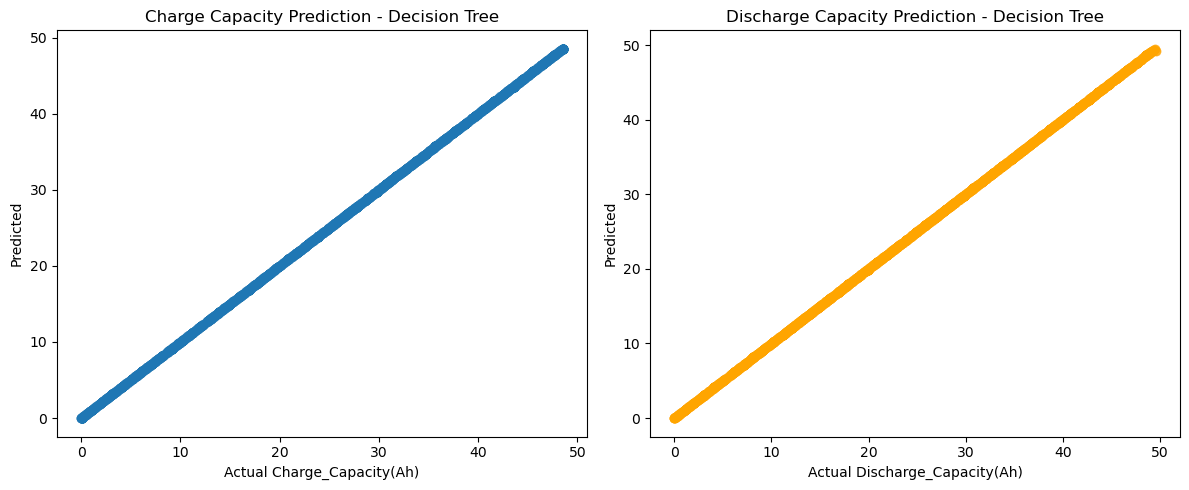

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Define input (X) and outputs (y)
features = df.drop(columns=['Charge_Capacity(Ah)', 'Discharge_Capacity(Ah)', 'Time', 'Date_Time'])
X = features
y_charge = df['Charge_Capacity(Ah)']
y_discharge = df['Discharge_Capacity(Ah)']

# Split dataset
X_train, X_test, yc_train, yc_test = train_test_split(X, y_charge, test_size=0.2, random_state=42)
_, _, yd_train, yd_test = train_test_split(X, y_discharge, test_size=0.2, random_state=42)

# Decision Tree model for Charge Capacity
dt_model_charge = DecisionTreeRegressor(random_state=42)
dt_model_charge.fit(X_train, yc_train)

# Decision Tree model for Discharge Capacity
dt_model_discharge = DecisionTreeRegressor(random_state=42)
dt_model_discharge.fit(X_train, yd_train)

# Predictions
yc_pred_dt = dt_model_charge.predict(X_test)
yd_pred_dt = dt_model_discharge.predict(X_test)

# Evaluation function
def evaluate(y_true, y_pred, label=""):
    print(f"--- {label} ---")
    print(f"MAE:  {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"R²:   {r2_score(y_true, y_pred):.4f}\n")

evaluate(yc_test, yc_pred_dt, "Charge_Capacity(Ah) - Decision Tree")
evaluate(yd_test, yd_pred_dt, "Discharge_Capacity(Ah) - Decision Tree")

# Comparison DataFrame
comparison_df = pd.DataFrame({
    'Actual_Charge': yc_test.values,
    'Predicted_Charge': yc_pred_dt,
    'Actual_Discharge': yd_test.values,
    'Predicted_Discharge': yd_pred_dt
})

# Print comparison
print(comparison_df.head(10))

# Optional: plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(yc_test, yc_pred_dt, alpha=0.5)
plt.xlabel("Actual Charge_Capacity(Ah)")
plt.ylabel("Predicted")
plt.title("Charge Capacity Prediction - Decision Tree")

plt.subplot(1, 2, 2)
plt.scatter(yd_test, yd_pred_dt, alpha=0.5, color='orange')
plt.xlabel("Actual Discharge_Capacity(Ah)")
plt.ylabel("Predicted")
plt.title("Discharge Capacity Prediction - Decision Tree")

plt.tight_layout()
plt.show()
